# Imports

In [181]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input, Lambda, BatchNormalization, ReLU

# Loading data

In [182]:
from sklearn.datasets import fetch_olivetti_faces

faces = fetch_olivetti_faces()
X = faces.images
X = np.expand_dims(X, axis=-1) 

y = faces.target
# Print the shape of the data
print(f'Shape of X (features): {X.shape}')  
print(f'Shape of y (labels): {y.shape}')    

# Number of occurances of each label 
unique_labels, counts = np.unique(y, return_counts=True)
face_counter = {}
for i in range(len(unique_labels)):
    face_counter[unique_labels[i]] = counts[i]

# Get image shape
IMG_SHAPE = X[0].shape
print(f"IMG_SHAPE = ", IMG_SHAPE)


print(unique_labels)

Shape of X (features): (400, 64, 64, 1)
Shape of y (labels): (400,)
IMG_SHAPE =  (64, 64, 1)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


# Data Augmentation

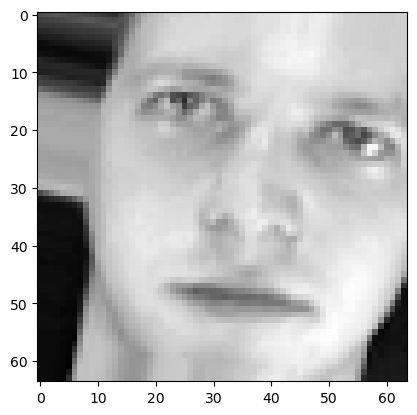

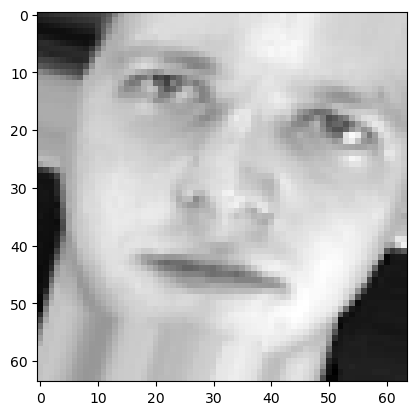

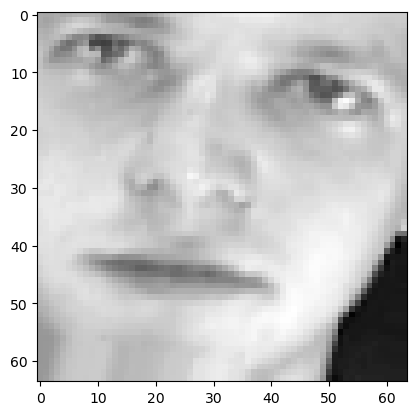

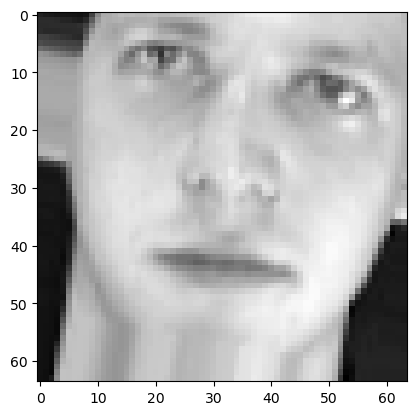

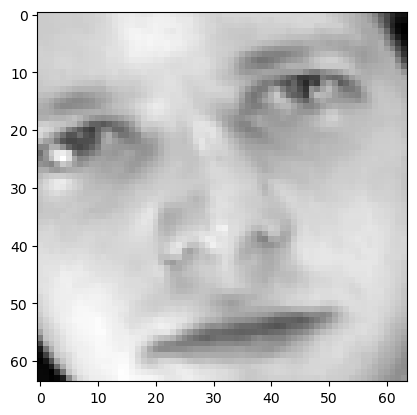

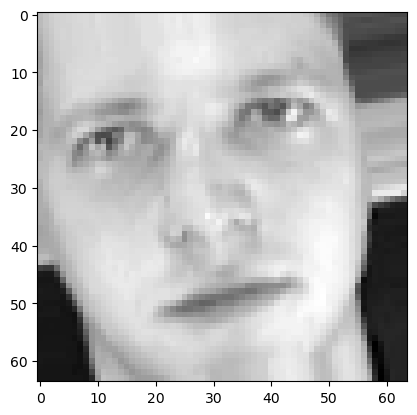

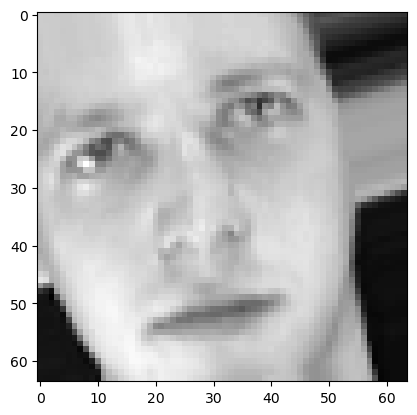

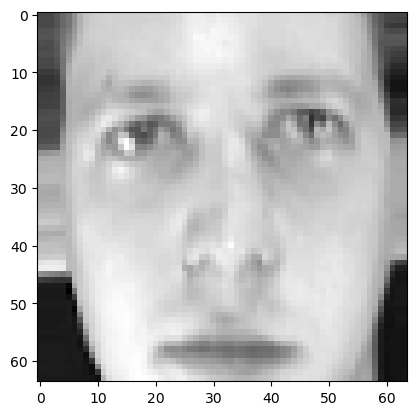

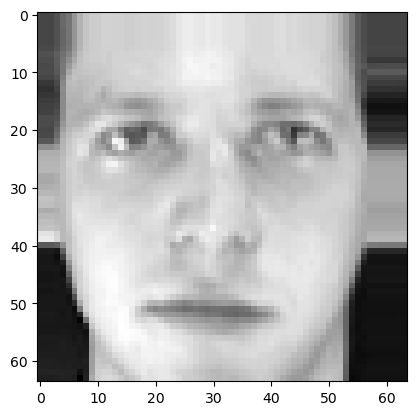

In [183]:
# Define data augmentation function
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def generate_augmented_images(image):
    # Define an ImageDataGenerator for normalized data
    datagen = ImageDataGenerator(
        rotation_range=15,        # Rotate images up to 15 degrees
        width_shift_range=0.1,    # Shift images horizontally by 10% of the width
        height_shift_range=0.1,   # Shift images vertically by 10% of the height
        zoom_range=0.2,           # Zoom in/out by up to 20%
        horizontal_flip=True,     # Randomly flip images horizontally
        brightness_range=[0.8, 1.2]  # Adjust brightness for normalized images
    )
    # Generate augmented images
    augmented_images = [(datagen.random_transform(example_face) / 255) for _ in range(9)]
    return np.array(augmented_images)

# Generate augmented images
augmented_images = generate_augmented_images(example_face)

# Visualize augmented images
for img in augmented_images:
    plt.imshow(img, cmap="gray")  # Use appropriate colormap for grayscale or RGB
    plt.show()




In [184]:
#X = X * 255

In [185]:
# Augment dataset 
print(f'Initial size = {X.shape}, {y.shape}')

#for i in range(len(y)):
#    # Expects a normalized image
#    image = X[i]
#    label = y[i]
#    augmented_images = generate_augmented_images(image)
#    X = np.concatenate((X, augmented_images), axis=0)
#    y = np.concatenate((y, np.repeat(label, len(augmented_images))))

print(f'Final size = {X.shape}, {y.shape}')


Initial size = (400, 64, 64, 1), (400,)
Final size = (400, 64, 64, 1), (400,)


In [186]:
#X = X / 255


# Creating pairs

In [187]:
def create_balanced_pairs(X, y, unique_labels, num_pairs=1000):
    """Creates an equal number of positive (same class) and negative (different class) pairs."""
    pairs = []
    labels = []
    
    half_pairs = num_pairs // 2  # Half positive, half negative
    
    # Step 1: Create positive pairs
    for _ in range(half_pairs):
        # Randomly select a class
        digit_class = np.random.choice(unique_labels)
        
        # Get indices for this class
        indices = np.where(y == digit_class)[0]
        
        # Select 2 random indices from the same class
        if len(indices) >= 2:
            idx1, idx2 = np.random.choice(indices, size=2, replace=False)
            image1 = X[idx1]
            image2 = X[idx2]
            
            # Add the pair and label it as 1 (positive pair)
            pairs.append([image1, image2])
            labels.append(1.)
    
    # Step 2: Create negative pairs
    for _ in range(half_pairs):
        # Randomly select two different classes
        class1, class2 = np.random.choice(unique_labels, size=2, replace=False)
        
        # Get indices for each class
        indices1 = np.where(y == class1)[0]
        indices2 = np.where(y == class2)[0]
        
        # Select one image from each class
        idx1 = np.random.choice(indices1)
        idx2 = np.random.choice(indices2)
        
        image1 = X[idx1]
        image2 = X[idx2]
        
        # Add the pair and label it as 0 (negative pair)
        pairs.append([image1, image2])
        labels.append(0.)
    
    # Convert pairs and labels to numpy arrays
    return np.array(pairs), np.array(labels)

In [188]:
def split_array(array, percentage):
    # Ensure the percentage is valid
    if not 0 <= percentage <= 1:
        raise ValueError("Percentage must be between 0 and 1.")
    
    # Calculate the split index
    split_index = int(len(array) * percentage)
    
    # Split and return the two arrays
    return array[:split_index], array[split_index:]

In [189]:
unique_labels_train, unique_labels_test = split_array(unique_labels, 0.75)
pairs_train, labels_train = create_balanced_pairs(X, y, unique_labels_train, 90000)
pairs_test, labels_test = create_balanced_pairs(X, y, unique_labels_test, 10000)
print(f'unique_labels_train = {unique_labels_train} \nunique_labels_test = {unique_labels_test}')

unique_labels_train = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29] 
unique_labels_test = [30 31 32 33 34 35 36 37 38 39]


# Visualize data

In [190]:
X1_train = np.array([pair[0] for pair in pairs_train])  # First image in each pair
X2_train = np.array([pair[1] for pair in pairs_train])  # Second image in each pair

X1_test = np.array([pair[0] for pair in pairs_test])  # First image in each pair
X2_test = np.array([pair[1] for pair in pairs_test])  # Second image in each pair

In [191]:
# Define the number of pairs to visualize and the layout
def visualize_pairs(X1,X2,y,num_pairs,pairs_per_row, title="Pair samples from Training Data",labels_title="True label",padding=10):
    if pairs_per_row == 0:
        return 
    rows = num_pairs // pairs_per_row

    # Create a figure with multiple subplots
    fig, axes = plt.subplots(rows, pairs_per_row * 2, figsize=(12, 3 * rows))
    fig.subplots_adjust(wspace=0.01, hspace=0.8)  # Minimal space between images in a pair; more between rows

    # Plot each pair with its label
    for i in range(num_pairs):
        row = i // pairs_per_row
        col = (i % pairs_per_row) * 2  # Each pair occupies two columns

        # Display the first image of the pair (X1_train[i])
        axes[row, col].imshow(X1[i], cmap='gray')  # Adjust cmap as needed
        axes[row, col].axis('off')

        # Display the second image of the pair (X2_train[i])
        axes[row, col + 1].imshow(X2[i], cmap='gray')  # Adjust cmap as needed
        axes[row, col + 1].axis('off')

        # Add the label above the pair, centered
        label = f"{labels_title}: {y[i]}"
        axes[row, col].set_title(label, fontsize=10, color="blue", pad=padding, loc='center', x=1.05)
        axes[row, col + 1].set_title("")  # Empty title for the second image in each pair

    plt.suptitle(title, fontsize=16)
    plt.show()

#visualize_pairs(X1_train, X2_train, labels_train,32,8)


# Build CNN Part

In [192]:
cnn_part = Sequential()
cnn_part.add(Conv2D(filters=64, kernel_size=(10,10), input_shape=IMG_SHAPE))
cnn_part.add(BatchNormalization())  
cnn_part.add(ReLU())  
cnn_part.add(MaxPooling2D(pool_size=(2, 2)))

cnn_part.add(Conv2D(128, (7, 7), strides=1))
cnn_part.add(BatchNormalization())  
cnn_part.add(ReLU())  
cnn_part.add(MaxPooling2D(pool_size=(2, 2)))

cnn_part.add(Conv2D(256, (4, 4), strides=1))
cnn_part.add(BatchNormalization())  
cnn_part.add(ReLU())  
cnn_part.add(MaxPooling2D(pool_size=(2, 2)))

cnn_part.add(Flatten())
cnn_part.add(BatchNormalization())  # Batch normalization before the dense layer's activation
cnn_part.add(Dense(128, activation="sigmoid"))


In [193]:
cnn_part.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 55, 55, 64)        6464      
                                                                 
 batch_normalization_20 (Bat  (None, 55, 55, 64)       256       
 chNormalization)                                                
                                                                 
 re_lu_15 (ReLU)             (None, 55, 55, 64)        0         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 27, 27, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 21, 21, 128)       401536    
                                                                 
 batch_normalization_21 (Bat  (None, 21, 21, 128)     

# Build SNN

In [194]:
input1, input2 = Input(shape=IMG_SHAPE, name="Image1"), Input(shape=IMG_SHAPE, name="Image2")
# Share the single output layer for both inputs
embedding1, embedding2 = cnn_part(input1), cnn_part(input2)

In [195]:
from tensorflow.keras import backend as K

# Creating the final layer of the SNN
def euclidean_distance(vectors):
    # vectors is a list containing two tensors
    x, y = vectors
    # Compute the Euclidean distance between x and y
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

def contrastive_loss(y_true, y_pred):
    """
    y_true: Binary labels (1 for similar pairs, 0 for dissimilar pairs)
    y_pred: Euclidean distances between the output embeddings
    """
    margin = 1.0  # This can be tuned
    positive_loss = y_true * K.square(y_pred)  # Loss for similar pairs
    negative_loss = (1 - y_true) * K.square(K.maximum(margin - y_pred, 0))  # Loss for dissimilar pairs
    return K.mean(positive_loss + negative_loss)  # Mean loss for the batch

In [196]:
merged = Lambda(lambda tensors: abs(tensors[0] - tensors[1]))([embedding1, embedding2])
final_output = Dense(1, activation='sigmoid')(merged)
#distance_layer = Lambda(euclidean_distance, output_shape=(1,))([embedding1, embedding2])
#final_output = Dense(1, activation='sigmoid')(distance_layer)

In [197]:
snn = Model((input1, input2), final_output)

In [198]:
from tensorflow.keras.optimizers import Adam

snn.compile(optimizer=Adam(),
              loss='binary_crossentropy',  # Loss function for classification
              metrics=['accuracy']
              )

In [199]:
snn.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Image1 (InputLayer)            [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 Image2 (InputLayer)            [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 sequential_5 (Sequential)      (None, 128)          1238592     ['Image1[0][0]',                 
                                                                  'Image2[0][0]']                 
                                                                                                  
 lambda_5 (Lambda)              (None, 128)          0           ['sequential_5[0][0]',     

# Train SNN

In [200]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=3)
snn.fit(x=[X1_train, X2_train], 
        y = labels_train, 
        batch_size = 64, 
        epochs=100,
        validation_data=([X1_test, X2_test], labels_test),
        callbacks=[es],
        shuffle=True)

Epoch 1/100
1407/1407 [==============================] - 1963s 1s/step - loss: 0.0662 - accuracy: 0.9873 - val_loss: 1.1403 - val_accuracy: 0.6119
Epoch 2/100
1407/1407 [==============================] - 2301s 2s/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 1.5868 - val_accuracy: 0.6039
Epoch 3/100
1407/1407 [==============================] - 2167s 2s/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.6630 - val_accuracy: 0.6113
Epoch 4/100
1407/1407 [==============================] - 2988s 2s/step - loss: 0.0132 - accuracy: 0.9972 - val_loss: 2.0740 - val_accuracy: 0.5833


# Test pair labelling accuracy

In [201]:
y_predict = snn.predict([X1_test,X2_test])
from sklearn.metrics import accuracy_score
Y_predict_decisions = []
for i in range(len(y_predict)):
    if y_predict[i] > 0.5:
        Y_predict_decisions.append(1)
    else:
        Y_predict_decisions.append(0)

# Calculate accuracy
accuracy = accuracy_score(labels_test, Y_predict_decisions)
print("Accuracy:", accuracy)

313/313 [==============================] - 50s 160ms/step
Accuracy: 0.5833


# Visualize predictions

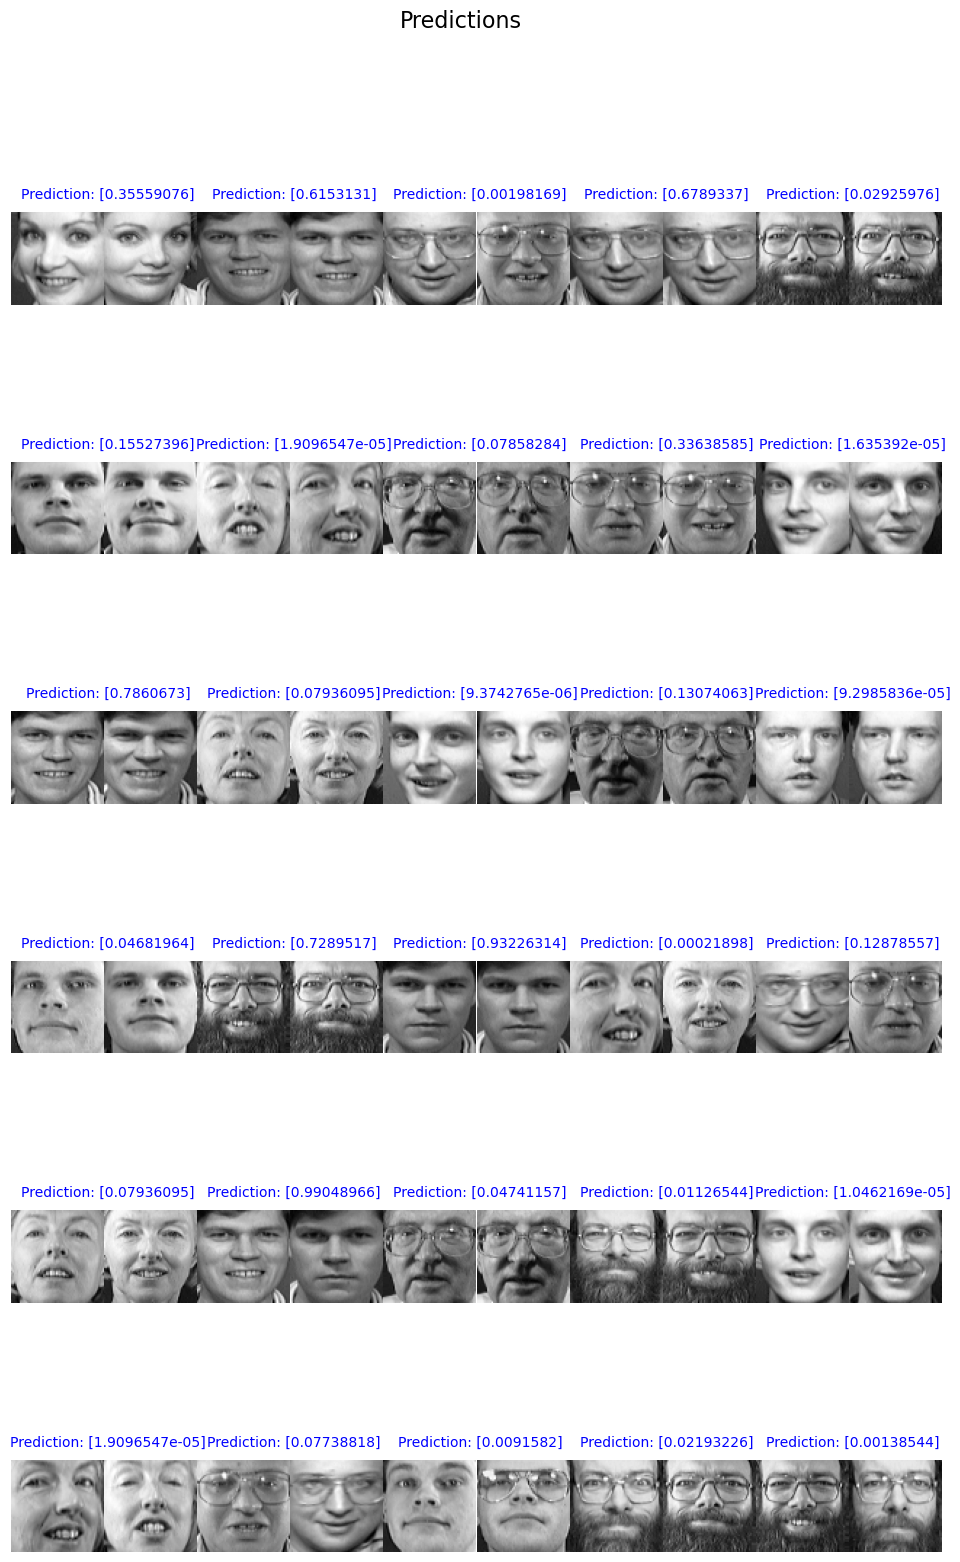

In [202]:
visualize_pairs(X1_test,X2_test,y_predict,30,5,"Predictions", "Prediction")

1/1 [==============================] - 0s 53ms/step


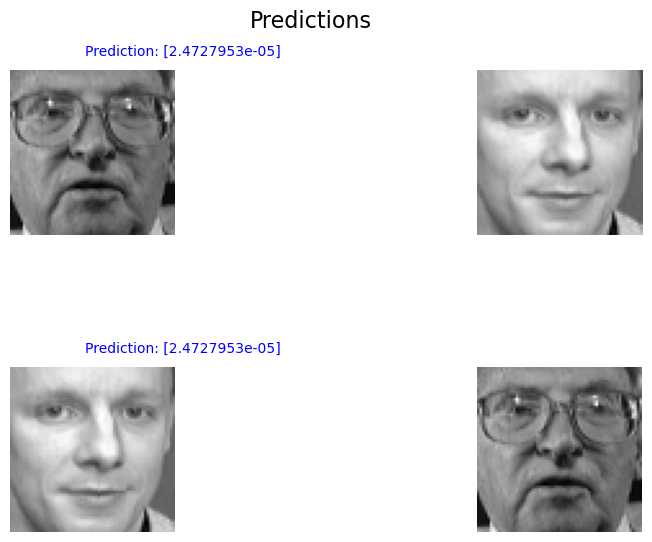

In [203]:
# Testing symmetry  
def get_random_pair(X):
    pair_indices = np.random.choice(len(X), size=2, replace=False)
    return X[pair_indices[0]], X[pair_indices[1]]

def similarity_test(person1, person2):
    X1 = np.array([person1, person2])
    X2 = np.array([person2, person1])
    predictions = snn.predict([X1,X2])
    visualize_pairs(X1,X2,predictions, 2, 1, "Predictions", "Prediction")
    return predictions
    #fig, axes = plt.subplots(1, 4, figsize=(12, 3 * rows))
    #fig.subplots_adjust(wspace=0.01, hspace=0.8) 

person1, person2 = get_random_pair(X)
similarity_predictions = similarity_test(person1, person2)




# One-shot classification testing

In [205]:
def classification_test(X, y):
    # Initialize input arrays
    X1, X2 = [], []
    # Get all images of testing dataset individuals
    indices_test = np.where(np.isin(y, unique_labels_test))[0]
    # Create an array containing a random image for each person to represent each person from the testing dataset (classes_images)
    index_input = np.random.choice(indices_test)
    #print(f"index_input = {index_input}")
    input_identity = y[index_input]
    input = X[index_input]

    # Create an array containing the identities of those people in the order their images are stored in classes_images, which is called classes_identities
    for unique_label in unique_labels_test:
        indices_person = np.where(y == unique_label)[0]
        index_test_image = np.random.choice(indices_person)
        test_image = X[index_test_image]
        X2.append(test_image)
        X1.append(input)

    X1, X2 = np.array(X1), np.array(X2)


    # Choose one random (classification_input) image of a random person from the testing dataset for the one-shot facial recognition test, 
    # different than the images in classes_images. 

    # Create an array of pairs of images, where the first pair is classification_input and the second is an image from classes_images. Span classes_images.

    # Use the model to make predictions on the similarity of the pairs
    predictions = snn.predict([X1,X2])
    max_index = np.argmax(predictions)
    result_classification = unique_labels_test[max_index]
    is_accurate = input_identity == result_classification
    # The pair with the highest score should correspond to the identity of the person compared to classification_input
    #print(f"The identity of the individual is {input_identity}\nThe predicted identity is {result_classification}")
    #print(f"The maximum score is {predictions[max_index]}")
    return is_accurate, index_input, predictions


def one_shot_trials(num_trials):
    count = 0
    for i in range(num_trials):
        if classification_test(X, y)[0]:
            count += 1
    print(count/num_trials)
one_shot_trials(1000)

1/1 [==============================] - 0s 143ms/step
0.672


# Next 
- Data Augmentation 
- LFW 
- Test with system 
- Generalize a visualization function